<a href="https://colab.research.google.com/github/dauparas/tensorflow_examples/blob/master/VAE_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Simple template for the Variational Autoencoder Model (VAE):

https://arxiv.org/pdf/1312.6114.pdf

In [1]:
#Step 1: import dependencies
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras import regularizers
import time
from __future__ import division

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

%matplotlib inline
plt.style.use('ggplot')

Using TensorFlow backend.


In [0]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=5000, centers=5, n_features=32,random_state=1)

In [0]:
def normalize_data(X):
  return (X-np.mean(X,axis=0)/np.std(X,axis=0))

In [0]:
X = normalize_data(X)

In [0]:
#Multivariate diagional
def create_encoder(inpt, latent_size):
  x = inpt
  x = tf.layers.dense(x, 32, tf.nn.relu)
  x = tf.layers.dense(x, 16, tf.nn.relu)
  loc = tf.layers.dense(x,latent_size)
  log_variance = tf.layers.dense(x, latent_size)
  scale = tf.nn.softplus(log_variance)
  return tfd.MultivariateNormalDiag(loc, scale)

def create_prior(latent_size):
  return tfd.MultivariateNormalDiag(loc=[0.0, 0.0], scale_diag=[1.0, 1.0])

def create_decoder(inpt, output_size):
  x = inpt
  x = tf.layers.dense(x, 16, tf.nn.relu)
  loc = tf.layers.dense(x, output_size)
  scale = tf.ones(output_size)
  return tfd.MultivariateNormalDiag(loc, scale)

In [0]:
#Connect encoder and decoder and define the loss function
tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=[None, X.shape[1]], name='x')
latent_size = 2

latent_prior = create_prior(latent_size=latent_size)
latent_posterior = create_encoder(x, latent_size=latent_size)

latent_sampled = latent_posterior.sample()
latent_mean = latent_posterior.mean()

posterior = create_decoder(latent_sampled, X.shape[1])

posterior_sampled = posterior.sample()
posterior_mean = posterior.mean()

rec_loss = -tf.reduce_mean(posterior.log_prob(x))
kl = tf.reduce_mean(tfd.kl_divergence(latent_posterior, latent_prior)) #analytical
#kl = tf.reduce_mean(latent_posterior.log_prob(latent_sampled)- latent_prior.log_prob(latent_sampled)) #approximate KL
beta=1.0
kl_loss = beta*kl
loss = rec_loss + kl_loss
optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)

In [0]:
#Helper function
def batch_generator(features, batch_size):
  """Function to create python generator to shuffle and split features into batches along the first dimension."""
  idx = np.arange(features.shape[0])
  np.random.shuffle(idx)
  for start_idx in range(0, features.shape[0], batch_size):
    end_idx = min(start_idx + batch_size, features.shape[0])
    part = idx[start_idx:end_idx]
    yield features[part,:]

In [77]:
n_epochs = 50
batch_size = 25
start = time.time()
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for i in range(n_epochs):
    gen = batch_generator(X, batch_size) #create batch generator
    total_loss = 0
    total_rec_loss = 0
    for j in range(np.int(X.shape[0]/batch_size)):
      x_batch = gen.__next__()
      _, total_loss_, total_rec_loss_ = sess.run([optimizer, loss, rec_loss], feed_dict={x: x_batch})
      total_loss += total_loss_
      total_rec_loss += total_rec_loss_
    if (i+1)% 10 == 0 or i == 0:
      latent_mean_, latent_sampled_, posterior_mean_, posterior_sampled_= sess.run([latent_mean, latent_sampled, posterior_mean, posterior_sampled], feed_dict ={x:X})
      end = time.time()
      print('epoch: {0}, total_loss: {1:.2f}, rec_loss: {2:.2f}, time: {3:.2f}'.format((i+1), 
                                       total_loss/(1+np.int(X.shape[0]/batch_size)), total_rec_loss/(1+np.int(X.shape[0]/batch_size)), end-start))
      start = time.time()

epoch: 1, total_loss: 449.13, rec_loss: 409.28, time: 0.97
epoch: 10, total_loss: 59.83, rec_loss: 46.28, time: 5.24
epoch: 20, total_loss: 54.09, rec_loss: 45.69, time: 5.54
epoch: 30, total_loss: 52.84, rec_loss: 45.58, time: 5.56
epoch: 40, total_loss: 52.35, rec_loss: 45.56, time: 5.53
epoch: 50, total_loss: 52.22, rec_loss: 45.58, time: 5.59


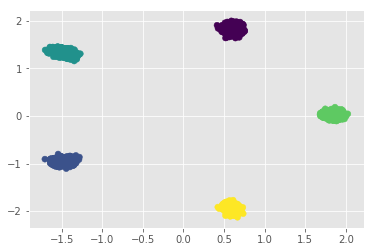

In [78]:
plt.scatter(latent_mean_[:,0],latent_mean_[:,1], c=y);

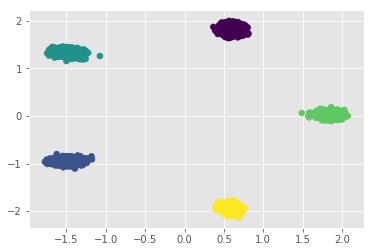

In [79]:
plt.scatter(latent_sampled_[:,0],latent_mean_[:,1], c=y);

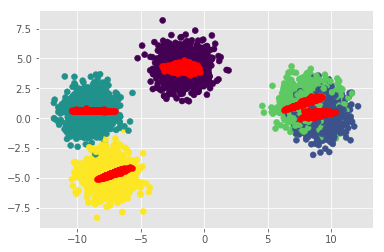

In [85]:
plt.scatter(X[:,0], X[:,1], c=y);
plt.scatter(posterior_mean_[:,0],posterior_mean_[:,1], c='red');

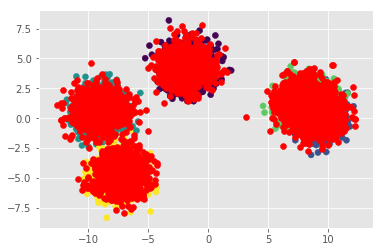

In [86]:
plt.scatter(X[:,0], X[:,1], c=y);
plt.scatter(posterior_sampled_[:,0],posterior_sampled_[:,1], c='red');